In [1]:
from google.colab import files

# !pip install kaggle
from google.colab import drive
drive.mount('/content/gdrive')

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

import kaggle
!kaggle datasets download -d manjilkarki/deepfake-and-real-images


Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
100% 1.68G/1.68G [00:10<00:00, 270MB/s]
100% 1.68G/1.68G [00:10<00:00, 167MB/s]


In [2]:
!unzip -o deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import random

random.seed(0)

# Define constants
input_size = (224, 224)
num_classes = 2  # Adjust this according to your dataset

# Data preprocessing without augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/Dataset/Train',
    target_size=input_size,
    batch_size=64,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/Dataset/Validation',
    target_size=input_size,
    batch_size=64,
    class_mode='categorical'
)

# Load pretrained EfficientNet model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(num_classes, activation='sigmoid', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint callback
checkpoint_path = '/content/gdrive/MyDrive/EfficientNetv2b0.keras'
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(train_generator, validation_data=valid_generator, epochs=5, callbacks=[checkpoint_callback])


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/5
2188/2188 [==============================] - 1000s 432ms/step - loss: 0.1136 - accuracy: 0.9659 - val_loss: 0.7214 - val_accuracy: 0.5019
Epoch 2/5
2188/2188 [==============================] - 928s 424ms/step - loss: 0.0554 - accuracy: 0.9796 - val_loss: 0.7570 - val_accuracy: 0.5787
Epoch 3/5
2188/2188 [==============================] - 926s 423ms/step - loss: 0.0459 - accuracy: 0.9832 - val_loss: 0.7166 - val_accuracy: 0.5043
Epoch 4/5
2188/2188 [==============================] - 928s 424ms/step - loss: 0.0404 - accuracy: 0.9848 - val_loss: 0.7080 - val_accuracy: 0.5607
Epoch 5/5
2188/2188 [==============================] - 927s 424ms/step - loss: 0.0353 - accuracy: 0.9867 - val_loss: 0.6960 - val_accuracy: 0.5078


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_size = (224,224)
# Evaluate the model on test data
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/Dataset/Test',
    target_size=input_size,
    batch_size=64,
    class_mode='categorical'
)
from tensorflow.keras.models import load_model
model = load_model("/content/gdrive/MyDrive/EfficientNetv2b0.keras")

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')


Found 10905 images belonging to 2 classes.
171/171 [==============================] - 32s 168ms/step - loss: 0.6958 - accuracy: 0.5027
Test accuracy: 0.5027051568031311


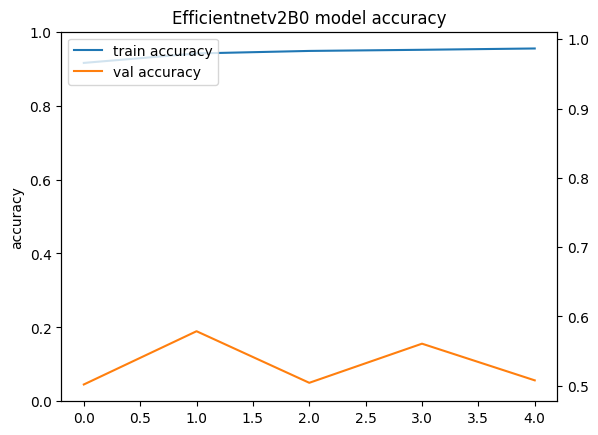

In [5]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()

plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
# plt.plot(history.history['loss'], label = 'train loss')
# plt.plot(history.history['val_loss'], label = 'val loss')
plt.title('Efficientnetv2B0 model accuracy')
plt.xlabel('epoch')
# ax2.set_ylabel("loss")
ax.set_ylabel("accuracy")

plt.legend(loc='upper left')
plt.show()